In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
from torch_geometric.data import Data

import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU, BatchNorm1d, Softmax, LeakyReLU
from torch.utils.data import random_split
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

In [66]:
import args
from trainer_allcoords import neuralGNN

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [68]:
supernode_indices = np.load('supernode_indices_allcoords.npy')

In [69]:
model = neuralGNN(time_window_size=args.time_window_size,
                      proc_nlp_hidden_dim=args.proc_nlp_hidden_dim,
                      time_nlp_hidden_dim=args.time_nlp_hidden_dim,
                      num_supernodes=len(supernode_indices),
                      super_nlp_hidden_dim_1=args.super_nlp_hidden_dim_1,
                      super_nlp_hidden_dim_2=args.super_nlp_hidden_dim_2,
                      num_layers=args.num_layers).to(device)

model.load_state_dict(torch.load('model_allcoords.pt'))
model.eval()

neuralGNN(
  (processor): ModuleList(
    (0): ProcessorLayer(21, 21)
    (1): ProcessorLayer(21, 21)
    (2): ProcessorLayer(21, 21)
    (3): ProcessorLayer(21, 21)
    (4): ProcessorLayer(21, 21)
  )
  (time_compress_mlp): Sequential(
    (0): Linear(in_features=21, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (supernode_mlp): Sequential(
    (0): Linear(in_features=457, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [78]:
#Get the test dataset
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

dataset = torch.load('/workspace/data_gen/pupil_allcoords_graphs.pt')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True)

In [79]:
#Use the trained model to compile a list of the predicted labels for each graph in the test dataset
gt_labels = []
pred_labels = []

total_num_epochs = len(test_loader)

for i, data in enumerate(test_loader):
    print('Epoch: {}/{}'.format(i, total_num_epochs))
    data = data.to(device)
    gt_labels.append(data.y.cpu().numpy())
    pred_labels.append(model(data, supernode_indices, device).cpu().detach().numpy())

Epoch: 0/434
Epoch: 1/434
Epoch: 2/434
Epoch: 3/434
Epoch: 4/434
Epoch: 5/434
Epoch: 6/434
Epoch: 7/434
Epoch: 8/434
Epoch: 9/434
Epoch: 10/434
Epoch: 11/434
Epoch: 12/434
Epoch: 13/434
Epoch: 14/434
Epoch: 15/434
Epoch: 16/434
Epoch: 17/434
Epoch: 18/434
Epoch: 19/434
Epoch: 20/434
Epoch: 21/434
Epoch: 22/434
Epoch: 23/434
Epoch: 24/434
Epoch: 25/434
Epoch: 26/434
Epoch: 27/434
Epoch: 28/434
Epoch: 29/434
Epoch: 30/434
Epoch: 31/434
Epoch: 32/434
Epoch: 33/434
Epoch: 34/434
Epoch: 35/434
Epoch: 36/434
Epoch: 37/434
Epoch: 38/434
Epoch: 39/434
Epoch: 40/434
Epoch: 41/434
Epoch: 42/434
Epoch: 43/434
Epoch: 44/434
Epoch: 45/434
Epoch: 46/434
Epoch: 47/434
Epoch: 48/434
Epoch: 49/434
Epoch: 50/434
Epoch: 51/434
Epoch: 52/434
Epoch: 53/434
Epoch: 54/434
Epoch: 55/434
Epoch: 56/434
Epoch: 57/434
Epoch: 58/434
Epoch: 59/434
Epoch: 60/434
Epoch: 61/434
Epoch: 62/434
Epoch: 63/434
Epoch: 64/434
Epoch: 65/434
Epoch: 66/434
Epoch: 67/434
Epoch: 68/434
Epoch: 69/434
Epoch: 70/434
Epoch: 71/434
Ep

In [80]:
gt_labels = np.concatenate(gt_labels)
pred_labels = np.concatenate(pred_labels)

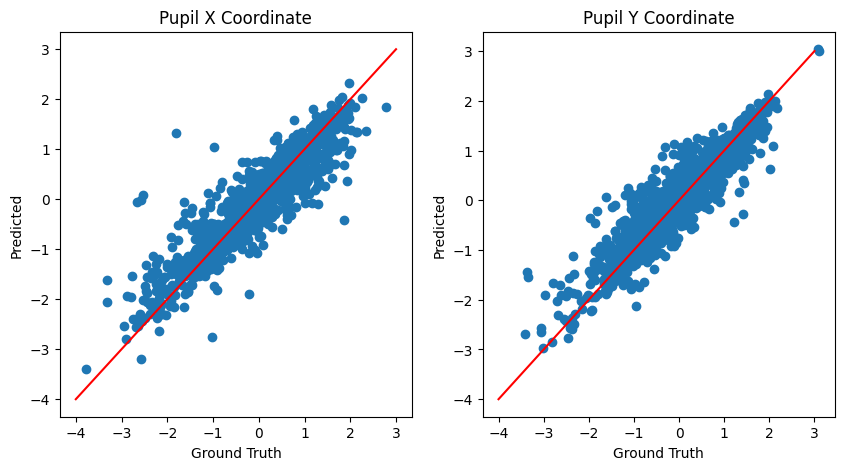

In [81]:
#Plot two subplots. The first shows the predicted vs. ground truth for the first dimension,
#and the second shows the predicted vs. ground truth for the second dimension.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.scatter(gt_labels[:,0], pred_labels[:,0])
ax1.plot([-4, 3], [-4, 3], c='r')
ax1.set_xlabel('Ground Truth')
ax1.set_ylabel('Predicted')
ax1.set_title('Pupil X Coordinate')
ax2.scatter(gt_labels[:,1], pred_labels[:,1])
ax2.plot([-4, 3], [-4, 3], c='r')
ax2.set_xlabel('Ground Truth')
ax2.set_ylabel('Predicted')
ax2.set_title('Pupil Y Coordinate')
plt.show()

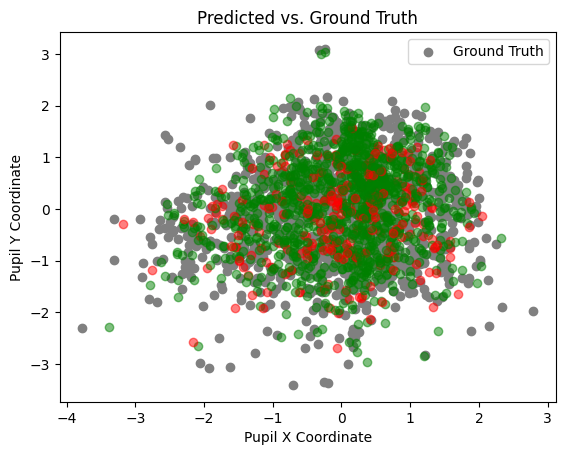

Number of green points: 1059
Number of red points: 241


In [82]:
#The first dimension is the x coordinate, and the second dimension is the y coordinate.
#Plot a superimposed 2D plot of the predicted and ground truth values.
#Plot the ground truth values as grey points
plt.scatter(gt_labels[:,0], gt_labels[:,1], c='grey', label='Ground Truth')

num_green = 0
num_red = 0

#Plot the predicted values with a slight translucency.
#Plot them as green points if they are within sqrt(1) units of the ground truth, and as red points otherwise.
for i in range(len(gt_labels)):
    if np.linalg.norm(gt_labels[i] - pred_labels[i]) < np.sqrt(2)/2:
        plt.scatter(pred_labels[i,0], pred_labels[i,1], c='green', alpha=0.5)
        num_green += 1
    else:
        plt.scatter(pred_labels[i,0], pred_labels[i,1], c='red', alpha=0.5)
        num_red += 1
plt.xlabel('Pupil X Coordinate')
plt.ylabel('Pupil Y Coordinate')
plt.title('Predicted vs. Ground Truth')
plt.legend()
plt.show()

print('Number of green points: {}'.format(num_green))
print('Number of red points: {}'.format(num_red))

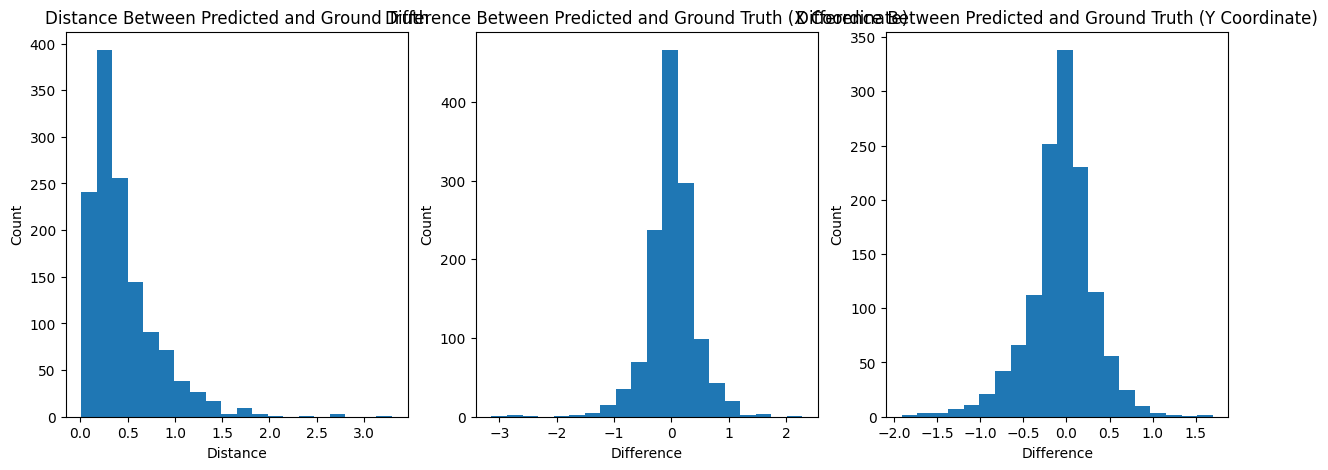

In [83]:
#Make three subplots.
#The first is a histogram that shows the distribution of the distances between the predicted and ground truth values.
#The second is a histogram of the difference and ground truth values for the first dimension.
#The third is a histogram of the difference and ground truth values for the second dimension.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.hist(np.linalg.norm(gt_labels - pred_labels, axis=1), bins=20)
ax1.set_xlabel('Distance')
ax1.set_ylabel('Count')
ax1.set_title('Distance Between Predicted and Ground Truth')
ax2.hist(gt_labels[:,0] - pred_labels[:,0], bins=20)
ax2.set_xlabel('Difference')
ax2.set_ylabel('Count')
ax2.set_title('Difference Between Predicted and Ground Truth (X Coordinate)')
ax3.hist(gt_labels[:,1] - pred_labels[:,1], bins=20)
ax3.set_xlabel('Difference')
ax3.set_ylabel('Count')
ax3.set_title('Difference Between Predicted and Ground Truth (Y Coordinate)')
plt.show()


In Python, I have a list of x-y ground truth coordinates in gt_labels and the corresponding predicted coordinates in a list called pred_labels. I was trying to write some code to create a gif that iteratively plotted a superposition of ground truth with predicted dots. The ground truth dots are gray and the predicted labels are green if within a distance of 0.5, otherwise they are red. I wanted the older dots to become progressively more transparent and to eventually disappear. This is the code I came up with but old dots are just disappearing immediately. Find the problem and code a working solution.

In [84]:
import random
import math
import imageio
import matplotlib.pyplot as plt

# Randomly sample 100 coordinates
sampled_indices = random.sample(range(len(gt_labels)), 100)

# Create a list of the sampled coordinates and their corresponding predictions
sampled_gt = [gt_labels[i] for i in sampled_indices]
sampled_pred = [pred_labels[i] for i in sampled_indices]

# Set up the plot parameters
x_min = min([min([coord[0] for coord in sampled_gt]), min([coord[0] for coord in sampled_pred])])
x_max = max([max([coord[0] for coord in sampled_gt]), max([coord[0] for coord in sampled_pred])])
y_min = min([min([coord[1] for coord in sampled_gt]), min([coord[1] for coord in sampled_pred])])
y_max = max([max([coord[1] for coord in sampled_gt]), max([coord[1] for coord in sampled_pred])])

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(xlim=(x_min, x_max), ylim=(y_min, y_max))
gray_dot, = ax.plot([], [], 'o', color='gray', alpha=0.5)
green_dot, = ax.plot([], [], 'o', color='green', alpha=0.5)
red_dot, = ax.plot([], [], 'o', color='red', alpha=0.5)

# Fix the legend to the bottom left corner
plt.legend((gray_dot, green_dot, red_dot), ('Ground Truth', 'Predicted (within 0.5)', 'Predicted (outside 0.5)'), loc='lower left')

#Set x and y axis labels
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

#Set a title
ax.set_title('Ground Truth vs. Predicted Coordinates')

# Set up the imageio writer
writer = imageio.get_writer('gt_vs_preds_2d.gif', mode='I', fps=2)

# Initialize the alpha value
alpha = 1.0

# Initialize lists to hold the plotted dots
gray_dots = []
colored_dots = []

# Iterate through the sampled coordinates
for i, (gt_coord, pred_coord) in enumerate(zip(sampled_gt, sampled_pred)):
    # Calculate the distance between the ground truth and predicted coordinates
    dist = math.sqrt((gt_coord[0] - pred_coord[0])**2 + (gt_coord[1] - pred_coord[1])**2)

    # Determine the color and alpha of the predicted dot
    if dist <= np.sqrt(2)/2:
        color = 'green'
    else:
        color = 'red'

    # Plot the ground truth and predicted coordinates
    gray_dots.append(ax.plot(gt_coord[0], gt_coord[1], 'o', color='gray', alpha=1.0))
    colored_dots.append(ax.plot(pred_coord[0], pred_coord[1], 'o', color=color, alpha=1.0))

    #iterate backwards through the lists of dots to fade them out
    alpha = 1.0
    for j in range(i, -1, -1):
        alpha -= 0.1
        if(alpha < 0):
            alpha = 0
        gray_dots[j][0].set_alpha(alpha)
        colored_dots[j][0].set_alpha(alpha)

    # Save the current plot as a frame in the animation
    plt.savefig('temp.png')
    writer.append_data(imageio.imread('temp.png'))

    # # Remove old dots
    # if i > 10:
    #     for dot in gray_dots[i-10]:
    #         dot.remove()
    #     for dot in green_dots[i-10]:
    #         dot.remove()

# Close the imageio writer and the plot
writer.close()
plt.close()

/tmp/ipykernel_9307/1452215638.py:71: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread('temp.png'))
